In [2]:
%pylab inline
import pandas as pd
import fastparquet 
import os,sys

Populating the interactive namespace from numpy and matplotlib


In [3]:
import lightgbm as lgb

In [4]:
if 0:
    sys.path.insert(0,os.getcwd()+"/../../src/main")
else:
    sys.path.insert(0, "/mnt/lanlep2019/src/main")
    os.environ['LOCAL']="/mnt/local"

In [5]:
!echo $LOCAL

/mnt/local


In [6]:
!mkdir -p $LOCAL/sandbox

In [7]:
HOME=os.environ['LOCAL']+"/sandbox"
os.chdir(HOME)
os.getcwd()

'/mnt/local/sandbox'

In [8]:
os.environ['LANLEP_HOME']=HOME

In [9]:
import data

In [24]:
if 0:
    !ls /home/lizhen09/lanlep2019/input/feat/*.parq | grep -v offset_.parq | xargs -L1  -IINPUT cp INPUT {HOME}/input/feat/
else:
    !cd {HOME}/input/feat/ && cat /mnt/lizhen-east2/notebook/fastseq/5/tmp.tar | tar xf - 
    !cd {HOME}/input/feat/ && cat /mnt/lizhen-east2/notebook/fastseq/5/tmppkl.tar | tar xf -     

In [10]:
reload (data)

<module 'data' from '/mnt/lanlep2019/src/main/data.pyc'>

In [12]:
if 1:
    a = fastparquet.ParquetFile("./input/feat/dense_train_seq_fwv_offset_0.parq").to_pandas()
    b = fastparquet.ParquetFile("./input/feat/dense_train_seq_fwv_offset_125.parq").to_pandas()
    traintest=(a+b)/2

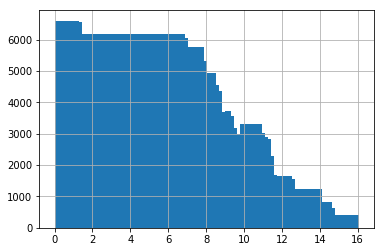

In [13]:
traintest.y.hist(bins=100);

In [14]:
np.abs(traintest.y-traintest.y.median()).mean()

3.02918898210172

In [54]:
traindf=traintest.drop('y',axis=1)
ydf=traintest.y
qdf=traindf.index.map(lambda u: int(u.split("_")[1]))

In [55]:
idx=~qdf.isin({0,16})
traindf=traindf[idx]
ydf=ydf[idx]
qdf=qdf[idx]

In [69]:
qdf=pd.DataFrame(qdf,index=traindf.index)
qdf.head()

index
index                      
quake_03_0200_105000      3
quake_06_0120_099000      6
quake_07_0296_013500      7
quake_03_0090_034500      3
quake_08_0137_055500      8

In [57]:
def f(u):
    qno, i, offset = [int(x) for x in u.split('_')[1:]]
    return  offset+(i)*150 * 1000
    
globaloffset = pd.Series(traindf.index.map(f), index=traindf.index).to_frame()
globaloffset['qno']=qdf
globaloffset=globaloffset.sort_values(['qno','index'])
globaloffset.columns=['offset','qno']
globaloffset['i']=range(len(globaloffset))
globaloffset.head()

/home/hadoop/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:7: FutureWarning: 'index' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version


offset  qno  i
index                               
quake_01_0000_000000       0    1  0
quake_01_0000_001500    1500    1  1
quake_01_0000_003000    3000    1  2
quake_01_0000_004500    4500    1  3
quake_01_0000_006000    6000    1  4

In [58]:
ydf.shape,traindf.shape

((409394,), (409394, 100))

In [22]:
if 1:
    strategy = {'type':'rand', "fold":5}
    types=['fwv']
    traintest2 = data.TrainTest('offset', offset=0, types=types, transform=None, valid_strategy=strategy)

In [23]:
testdf=traintest2.get_test_data()
testdf.shape

(2624, 100)

In [59]:
quakes=set(range(1,16))
quakes

{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15}

In [60]:
import utils
n_thread= utils.get_num_thread()
n_thread

15

In [26]:
n_thread=3

In [61]:
params = {'num_leaves': 54,
          #'min_data_in_leaf': 79,
          'objective': 'huber',
          'max_depth': -1,
          'learning_rate': 0.01,
          "boosting": "gbdt",
          "bagging_freq": 5,
          "bagging_fraction": 0.8126672064208567,
          "bagging_seed": 11,
          "metric": 'mae',
          "verbosity": -1,
          'reg_alpha': 0.1302650970728192,
          'reg_lambda': 0.3603427518866501
         }

In [62]:
from sklearn import model_selection


In [66]:
def filtered_index(n_skip=100, os=0):
    idx=globaloffset['i'].map(lambda u: u%n_skip==os)
    return idx
    

In [70]:
n_skip=100

In [75]:
testpred=[]
exqnos={}
if 1:
    print 'excludes ', exqnos
    dataidx= (~(qdf['index'].isin(exqnos)) ) & filtered_index(n_skip)
    X=traindf[dataidx]
    Y=ydf[dataidx]
    kf = model_selection.KFold(n_splits=5,shuffle=True)
    for train_index, test_index in kf.split(X):
        Xtr,ytr,Xte,yte=X.iloc[train_index],Y.iloc[train_index],X.iloc[test_index],Y.iloc[test_index],
        Xtr,ytr,Xte,yte=[u.values for u in [Xtr,ytr,Xte,yte]]
        print Xtr.shape,ytr.shape,Xte.shape,yte.shape
        model = lgb.LGBMRegressor(n_estimators = 50000, n_jobs = n_thread, **params)
        model.fit(Xtr, ytr, 
                        eval_set=[(Xtr, ytr), (Xte, yte)], eval_metric='mae',
                        verbose=50, early_stopping_rounds=200)
        a = model.predict(testdf.values,  num_iteration=model.best_iteration_)
        testpred.append(a)

excludes  {}


/home/hadoop/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


(3275, 100) (3275,) (819, 100) (819,)
Training until validation scores don't improve for 200 rounds.
[50]	training's l1: 2.79082	valid_1's l1: 2.78359
[100]	training's l1: 2.59514	valid_1's l1: 2.62588
[150]	training's l1: 2.41791	valid_1's l1: 2.48928
[200]	training's l1: 2.26149	valid_1's l1: 2.37488
[250]	training's l1: 2.12113	valid_1's l1: 2.27433
[300]	training's l1: 1.99832	valid_1's l1: 2.19736
[350]	training's l1: 1.89107	valid_1's l1: 2.13669
[400]	training's l1: 1.80072	valid_1's l1: 2.08564
[450]	training's l1: 1.72124	valid_1's l1: 2.04486
[500]	training's l1: 1.65083	valid_1's l1: 2.01275
[550]	training's l1: 1.58676	valid_1's l1: 1.98977
[600]	training's l1: 1.52958	valid_1's l1: 1.96941
[650]	training's l1: 1.47565	valid_1's l1: 1.9554
[700]	training's l1: 1.42539	valid_1's l1: 1.9461
[750]	training's l1: 1.37749	valid_1's l1: 1.93663
[800]	training's l1: 1.33313	valid_1's l1: 1.93222
[850]	training's l1: 1.28946	valid_1's l1: 1.92666
[900]	training's l1: 1.24902	valid_

5.580783775562299 5.321133283466557


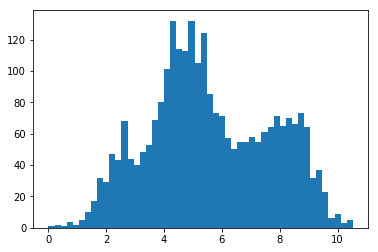

In [76]:
pred = np.median(np.array(testpred).T,1)
print np.mean(pred),np.median(pred)
plt.hist(pred,bins=50);

In [77]:
a=pd.DataFrame(pred,index=testdf.index).reset_index()
a.columns=["seg_id","time_to_failure"]
print a.shape
a.to_csv(os.environ['LOCAL']+"/input/sub/test_fwv_dense_5fold_lgb_median_skip-{}_rm-{}.csv".format(n_skip, "-".join([str(u) for u in exqnos])),index=None)

(2624, 2)


In [78]:
n_skip=120

In [79]:
testpred=[]
exqnos={}
if 1:
    print 'excludes ', exqnos
    dataidx= (~(qdf['index'].isin(exqnos)) ) & filtered_index(n_skip)
    X=traindf[dataidx]
    Y=ydf[dataidx]
    kf = model_selection.KFold(n_splits=5,shuffle=True)
    for train_index, test_index in kf.split(X):
        Xtr,ytr,Xte,yte=X.iloc[train_index],Y.iloc[train_index],X.iloc[test_index],Y.iloc[test_index],
        Xtr,ytr,Xte,yte=[u.values for u in [Xtr,ytr,Xte,yte]]
        print Xtr.shape,ytr.shape,Xte.shape,yte.shape
        model = lgb.LGBMRegressor(n_estimators = 50000, n_jobs = n_thread, **params)
        model.fit(Xtr, ytr, 
                        eval_set=[(Xtr, ytr), (Xte, yte)], eval_metric='mae',
                        verbose=50, early_stopping_rounds=200)
        a = model.predict(testdf.values,  num_iteration=model.best_iteration_)
        testpred.append(a)

excludes  {}


/home/hadoop/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


(2729, 100) (2729,) (683, 100) (683,)
Training until validation scores don't improve for 200 rounds.
[50]	training's l1: 2.77593	valid_1's l1: 2.82852
[100]	training's l1: 2.57186	valid_1's l1: 2.67265
[150]	training's l1: 2.38722	valid_1's l1: 2.53814
[200]	training's l1: 2.22103	valid_1's l1: 2.42227
[250]	training's l1: 2.07565	valid_1's l1: 2.32528
[300]	training's l1: 1.94615	valid_1's l1: 2.24678
[350]	training's l1: 1.83401	valid_1's l1: 2.18951
[400]	training's l1: 1.73592	valid_1's l1: 2.14688
[450]	training's l1: 1.65026	valid_1's l1: 2.11395
[500]	training's l1: 1.57578	valid_1's l1: 2.09095
[550]	training's l1: 1.50819	valid_1's l1: 2.07527
[600]	training's l1: 1.44761	valid_1's l1: 2.06153
[650]	training's l1: 1.39081	valid_1's l1: 2.04942
[700]	training's l1: 1.33789	valid_1's l1: 2.04362
[750]	training's l1: 1.28541	valid_1's l1: 2.03599
[800]	training's l1: 1.23581	valid_1's l1: 2.02879
[850]	training's l1: 1.19059	valid_1's l1: 2.02246
[900]	training's l1: 1.14616	vali

5.543456835366893 5.241032176394647


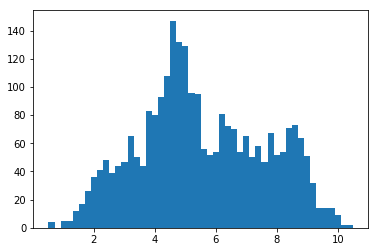

In [80]:
pred = np.median(np.array(testpred).T,1)
print np.mean(pred),np.median(pred)
plt.hist(pred,bins=50);

In [81]:
a=pd.DataFrame(pred,index=testdf.index).reset_index()
a.columns=["seg_id","time_to_failure"]
print a.shape
a.to_csv(os.environ['LOCAL']+"/input/sub/test_fwv_dense_5fold_lgb_median_skip-{}_rm-{}.csv".format(n_skip, "-".join([str(u) for u in exqnos])),index=None)

(2624, 2)


In [82]:
n_skip=80

In [83]:
testpred=[]
exqnos={}
if 1:
    print 'excludes ', exqnos
    dataidx= (~(qdf['index'].isin(exqnos)) ) & filtered_index(n_skip)
    X=traindf[dataidx]
    Y=ydf[dataidx]
    kf = model_selection.KFold(n_splits=5,shuffle=True)
    for train_index, test_index in kf.split(X):
        Xtr,ytr,Xte,yte=X.iloc[train_index],Y.iloc[train_index],X.iloc[test_index],Y.iloc[test_index],
        Xtr,ytr,Xte,yte=[u.values for u in [Xtr,ytr,Xte,yte]]
        print Xtr.shape,ytr.shape,Xte.shape,yte.shape
        model = lgb.LGBMRegressor(n_estimators = 50000, n_jobs = n_thread, **params)
        model.fit(Xtr, ytr, 
                        eval_set=[(Xtr, ytr), (Xte, yte)], eval_metric='mae',
                        verbose=50, early_stopping_rounds=200)
        a = model.predict(testdf.values,  num_iteration=model.best_iteration_)
        testpred.append(a)

excludes  {}


/home/hadoop/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


(4094, 100) (4094,) (1024, 100) (1024,)
Training until validation scores don't improve for 200 rounds.
[50]	training's l1: 2.78772	valid_1's l1: 2.81125
[100]	training's l1: 2.59061	valid_1's l1: 2.66019
[150]	training's l1: 2.41461	valid_1's l1: 2.52914
[200]	training's l1: 2.26021	valid_1's l1: 2.41545
[250]	training's l1: 2.12524	valid_1's l1: 2.32453
[300]	training's l1: 2.0061	valid_1's l1: 2.25121
[350]	training's l1: 1.90481	valid_1's l1: 2.1947
[400]	training's l1: 1.81746	valid_1's l1: 2.14967
[450]	training's l1: 1.74404	valid_1's l1: 2.11135
[500]	training's l1: 1.67981	valid_1's l1: 2.08364
[550]	training's l1: 1.62182	valid_1's l1: 2.06279
[600]	training's l1: 1.56968	valid_1's l1: 2.04719
[650]	training's l1: 1.52126	valid_1's l1: 2.03711
[700]	training's l1: 1.47594	valid_1's l1: 2.02894
[750]	training's l1: 1.43301	valid_1's l1: 2.02283
[800]	training's l1: 1.39345	valid_1's l1: 2.01807
[850]	training's l1: 1.35514	valid_1's l1: 2.01614
[900]	training's l1: 1.31876	vali

[850]	training's l1: 1.37735	valid_1's l1: 1.91032
[900]	training's l1: 1.3397	valid_1's l1: 1.90793
[950]	training's l1: 1.30463	valid_1's l1: 1.90697
[1000]	training's l1: 1.27	valid_1's l1: 1.90669
[1050]	training's l1: 1.23624	valid_1's l1: 1.90459
[1100]	training's l1: 1.20326	valid_1's l1: 1.90411
[1150]	training's l1: 1.17212	valid_1's l1: 1.90553
[1200]	training's l1: 1.14063	valid_1's l1: 1.904
[1250]	training's l1: 1.11092	valid_1's l1: 1.90504
Early stopping, best iteration is:
[1072]	training's l1: 1.22173	valid_1's l1: 1.9038


5.549279125488898 5.267868037687567


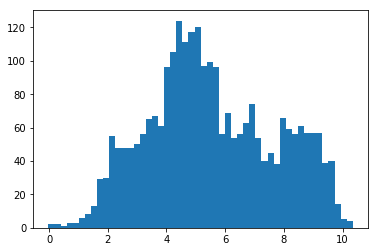

In [84]:
pred = np.median(np.array(testpred).T,1)
print np.mean(pred),np.median(pred)
plt.hist(pred,bins=50);

In [85]:
a=pd.DataFrame(pred,index=testdf.index).reset_index()
a.columns=["seg_id","time_to_failure"]
print a.shape
a.to_csv(os.environ['LOCAL']+"/input/sub/test_fwv_dense_5fold_lgb_median_skip-{}_rm-{}.csv".format(n_skip, "-".join([str(u) for u in exqnos])),index=None)

(2624, 2)


In [94]:
n_skip=40

In [95]:
testpred=[]
exqnos={}
if 1:
    print 'excludes ', exqnos
    dataidx= (~(qdf['index'].isin(exqnos)) ) & filtered_index(n_skip)
    X=traindf[dataidx]
    Y=ydf[dataidx]
    kf = model_selection.KFold(n_splits=5,shuffle=True)
    for train_index, test_index in kf.split(X):
        Xtr,ytr,Xte,yte=X.iloc[train_index],Y.iloc[train_index],X.iloc[test_index],Y.iloc[test_index],
        Xtr,ytr,Xte,yte=[u.values for u in [Xtr,ytr,Xte,yte]]
        print Xtr.shape,ytr.shape,Xte.shape,yte.shape
        model = lgb.LGBMRegressor(n_estimators = 50000, n_jobs = n_thread, **params)
        model.fit(Xtr, ytr, 
                        eval_set=[(Xtr, ytr), (Xte, yte)], eval_metric='mae',
                        verbose=50, early_stopping_rounds=200)
        a = model.predict(testdf.values,  num_iteration=model.best_iteration_)
        testpred.append(a)

excludes  {}


/home/hadoop/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


(8188, 100) (8188,) (2047, 100) (2047,)
Training until validation scores don't improve for 200 rounds.
[50]	training's l1: 2.79562	valid_1's l1: 2.82479
[100]	training's l1: 2.61476	valid_1's l1: 2.66611
[150]	training's l1: 2.4545	valid_1's l1: 2.52637
[200]	training's l1: 2.3137	valid_1's l1: 2.40916
[250]	training's l1: 2.19328	valid_1's l1: 2.31012
[300]	training's l1: 2.08923	valid_1's l1: 2.22846
[350]	training's l1: 2.00099	valid_1's l1: 2.15987
[400]	training's l1: 1.92673	valid_1's l1: 2.10584
[450]	training's l1: 1.86446	valid_1's l1: 2.06487
[500]	training's l1: 1.81111	valid_1's l1: 2.03214
[550]	training's l1: 1.76481	valid_1's l1: 2.0072
[600]	training's l1: 1.72496	valid_1's l1: 1.98844
[650]	training's l1: 1.68818	valid_1's l1: 1.97458
[700]	training's l1: 1.65414	valid_1's l1: 1.96333
[750]	training's l1: 1.62392	valid_1's l1: 1.95359
[800]	training's l1: 1.59432	valid_1's l1: 1.94484
[850]	training's l1: 1.56664	valid_1's l1: 1.93681
[900]	training's l1: 1.53974	valid

[7850]	training's l1: 0.180306	valid_1's l1: 1.82144
Early stopping, best iteration is:
[7665]	training's l1: 0.192582	valid_1's l1: 1.821
(8188, 100) (8188,) (2047, 100) (2047,)
Training until validation scores don't improve for 200 rounds.
[50]	training's l1: 2.80663	valid_1's l1: 2.78219
[100]	training's l1: 2.62469	valid_1's l1: 2.62664
[150]	training's l1: 2.46341	valid_1's l1: 2.49084
[200]	training's l1: 2.32222	valid_1's l1: 2.37369
[250]	training's l1: 2.20033	valid_1's l1: 2.27499
[300]	training's l1: 2.09634	valid_1's l1: 2.19312
[350]	training's l1: 2.00787	valid_1's l1: 2.12769
[400]	training's l1: 1.93409	valid_1's l1: 2.07553
[450]	training's l1: 1.87229	valid_1's l1: 2.03554
[500]	training's l1: 1.82	valid_1's l1: 2.0046
[550]	training's l1: 1.77417	valid_1's l1: 1.97977
[600]	training's l1: 1.73369	valid_1's l1: 1.9582
[650]	training's l1: 1.69782	valid_1's l1: 1.94223
[700]	training's l1: 1.6646	valid_1's l1: 1.92924
[750]	training's l1: 1.63326	valid_1's l1: 1.91834


[2200]	training's l1: 1.0417	valid_1's l1: 1.87765
[2250]	training's l1: 1.02657	valid_1's l1: 1.87616
[2300]	training's l1: 1.01194	valid_1's l1: 1.87626
[2350]	training's l1: 0.998214	valid_1's l1: 1.87555
[2400]	training's l1: 0.983918	valid_1's l1: 1.87493
[2450]	training's l1: 0.970154	valid_1's l1: 1.87449
[2500]	training's l1: 0.956528	valid_1's l1: 1.87452
[2550]	training's l1: 0.942882	valid_1's l1: 1.87352
[2600]	training's l1: 0.929145	valid_1's l1: 1.87313
[2650]	training's l1: 0.915493	valid_1's l1: 1.8725
[2700]	training's l1: 0.902553	valid_1's l1: 1.8716
[2750]	training's l1: 0.889514	valid_1's l1: 1.87111
[2800]	training's l1: 0.876677	valid_1's l1: 1.87064
[2850]	training's l1: 0.863695	valid_1's l1: 1.86942
[2900]	training's l1: 0.851082	valid_1's l1: 1.86842
[2950]	training's l1: 0.838973	valid_1's l1: 1.86777
[3000]	training's l1: 0.826893	valid_1's l1: 1.86713
[3050]	training's l1: 0.814979	valid_1's l1: 1.86686
[3100]	training's l1: 0.802971	valid_1's l1: 1.86566

[5500]	training's l1: 0.39098	valid_1's l1: 1.85398
[5550]	training's l1: 0.384888	valid_1's l1: 1.85376
[5600]	training's l1: 0.378926	valid_1's l1: 1.85338
[5650]	training's l1: 0.37304	valid_1's l1: 1.85357
[5700]	training's l1: 0.367284	valid_1's l1: 1.85347
[5750]	training's l1: 0.361827	valid_1's l1: 1.85348
[5800]	training's l1: 0.355829	valid_1's l1: 1.85348
Early stopping, best iteration is:
[5605]	training's l1: 0.378296	valid_1's l1: 1.85335
(8188, 100) (8188,) (2047, 100) (2047,)
Training until validation scores don't improve for 200 rounds.
[50]	training's l1: 2.80994	valid_1's l1: 2.77269
[100]	training's l1: 2.62901	valid_1's l1: 2.61246
[150]	training's l1: 2.46789	valid_1's l1: 2.47729
[200]	training's l1: 2.32683	valid_1's l1: 2.3613
[250]	training's l1: 2.20544	valid_1's l1: 2.26299
[300]	training's l1: 2.10128	valid_1's l1: 2.18068
[350]	training's l1: 2.01199	valid_1's l1: 2.11483
[400]	training's l1: 1.93789	valid_1's l1: 2.06303
[450]	training's l1: 1.87583	valid

5.842574580766157 5.389484574519155


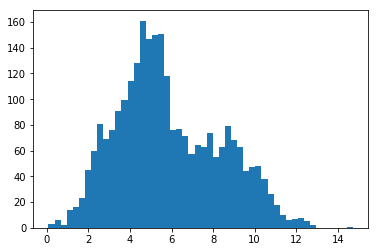

In [96]:
pred = np.median(np.array(testpred).T,1)
print np.mean(pred),np.median(pred)
plt.hist(pred,bins=50);

In [97]:
a=pd.DataFrame(pred,index=testdf.index).reset_index()
a.columns=["seg_id","time_to_failure"]
print a.shape
a.to_csv(os.environ['LOCAL']+"/input/sub/test_fwv_dense_5fold_lgb_median_skip-{}_rm-{}.csv".format(n_skip, "-".join([str(u) for u in exqnos])),index=None)

(2624, 2)


In [90]:
n_skip=140

In [91]:
testpred=[]
exqnos={}
if 1:
    print 'excludes ', exqnos
    dataidx= (~(qdf['index'].isin(exqnos)) ) & filtered_index(n_skip)
    X=traindf[dataidx]
    Y=ydf[dataidx]
    kf = model_selection.KFold(n_splits=5,shuffle=True)
    for train_index, test_index in kf.split(X):
        Xtr,ytr,Xte,yte=X.iloc[train_index],Y.iloc[train_index],X.iloc[test_index],Y.iloc[test_index],
        Xtr,ytr,Xte,yte=[u.values for u in [Xtr,ytr,Xte,yte]]
        print Xtr.shape,ytr.shape,Xte.shape,yte.shape
        model = lgb.LGBMRegressor(n_estimators = 50000, n_jobs = n_thread, **params)
        model.fit(Xtr, ytr, 
                        eval_set=[(Xtr, ytr), (Xte, yte)], eval_metric='mae',
                        verbose=50, early_stopping_rounds=200)
        a = model.predict(testdf.values,  num_iteration=model.best_iteration_)
        testpred.append(a)

excludes  {}


/home/hadoop/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


(2340, 100) (2340,) (585, 100) (585,)
Training until validation scores don't improve for 200 rounds.
[50]	training's l1: 2.78687	valid_1's l1: 2.78629
[100]	training's l1: 2.57962	valid_1's l1: 2.63375
[150]	training's l1: 2.38938	valid_1's l1: 2.50186
[200]	training's l1: 2.21745	valid_1's l1: 2.39818
[250]	training's l1: 2.05975	valid_1's l1: 2.31349
[300]	training's l1: 1.92406	valid_1's l1: 2.24203
[350]	training's l1: 1.80594	valid_1's l1: 2.18691
[400]	training's l1: 1.70087	valid_1's l1: 2.14191
[450]	training's l1: 1.60782	valid_1's l1: 2.11035
[500]	training's l1: 1.5271	valid_1's l1: 2.08794
[550]	training's l1: 1.45391	valid_1's l1: 2.06922
[600]	training's l1: 1.38736	valid_1's l1: 2.0537
[650]	training's l1: 1.32593	valid_1's l1: 2.04317
[700]	training's l1: 1.26774	valid_1's l1: 2.03504
[750]	training's l1: 1.21108	valid_1's l1: 2.03026
[800]	training's l1: 1.15882	valid_1's l1: 2.02821
[850]	training's l1: 1.11015	valid_1's l1: 2.025
[900]	training's l1: 1.06343	valid_1'

5.576401350510443 5.227798796423036


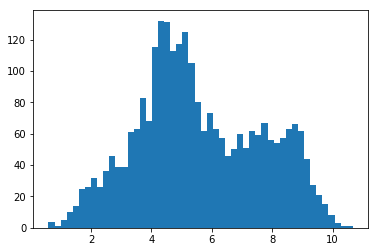

In [92]:
pred = np.median(np.array(testpred).T,1)
print np.mean(pred),np.median(pred)
plt.hist(pred,bins=50);

In [93]:
a=pd.DataFrame(pred,index=testdf.index).reset_index()
a.columns=["seg_id","time_to_failure"]
print a.shape
a.to_csv(os.environ['LOCAL']+"/input/sub/test_fwv_dense_5fold_lgb_median_skip-{}_rm-{}.csv".format(n_skip, "-".join([str(u) for u in exqnos])),index=None)

(2624, 2)
